In [43]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import seaborn as sns
from PIL import Image
import pandas as pd
import tensorflow as tf

import keras

import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [44]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "FFT/"
# Change loading set
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.4,
                                             subset='training',
                                             seed=42)
# Change laoding set
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.4,
                                             subset='validation',
                                             seed=42)


Found 3560 files belonging to 6 classes.
Using 2136 files for training.
Found 3560 files belonging to 6 classes.
Using 1424 files for validation.


2023-11-02 10:25:02.964133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]
2023-11-02 10:25:02.965137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]


['B1', 'B2', 'T1', 'T2', 'T3', 'UD']


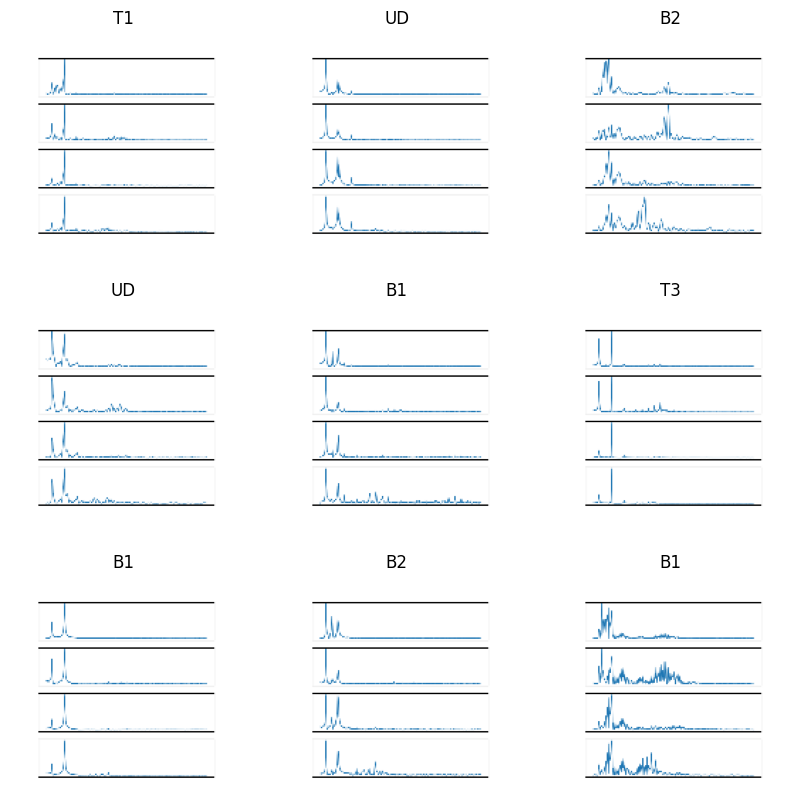

In [45]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
print(class_names)

In [46]:
for image_batch, labels_batch in train_dataset:
    print("image batch shape = " , image_batch.shape)
    print("lable batch shape = " , labels_batch.shape)
    break

2023-11-02 10:25:16.716089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]
2023-11-02 10:25:16.716571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]


image batch shape =  (32, 160, 160, 3)
lable batch shape =  (32,)


In [47]:
# prevent memory bottleneck and increase performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [48]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    tfl.Rescaling(1./255, input_shape=input_shape)
    
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters=8, kernel_size=4, padding='same')(input_img)
    
    ## RELU
    A1 = tfl.ReLU()(Z1)
    
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters=16, kernel_size=2, padding='same')(P1)
    
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units=6, activation='softmax')(F)
    # YOUR CODE STARTS HERE
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [49]:
model = convolutional_model((160, 160, 3))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# keras.utils.plot_model(model, "mk2", show_shapes=True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 8)       392       
                                                                 
 re_lu_2 (ReLU)              (None, 160, 160, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        528       
                                                                 
 re_lu_3 (ReLU)              (None, 20, 20, 16)        0         
                                                           

In [50]:
%%time
epochs=200
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/200


2023-11-02 10:27:49.925722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]
2023-11-02 10:27:49.926022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_l

67/67 [==============================] - ETA: 0s - loss: 20.4125 - accuracy: 0.1980

2023-11-02 10:27:56.901023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1424]
	 [[{{node Placeholder/_4}}]]
2023-11-02 10:27:56.901476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1424]
	 [[{{node Placeholder/_4}}]]


67/67 [==============================] - 9s 120ms/step - loss: 20.4125 - accuracy: 0.1980 - val_loss: 3.5827 - val_accuracy: 0.2177
Epoch 2/200
67/67 [==============================] - 9s 125ms/step - loss: 3.3119 - accuracy: 0.2252 - val_loss: 3.2511 - val_accuracy: 0.2205
Epoch 3/200
67/67 [==============================] - 9s 130ms/step - loss: 3.0859 - accuracy: 0.2374 - val_loss: 2.9534 - val_accuracy: 0.2324
Epoch 4/200
67/67 [==============================] - 9s 138ms/step - loss: 2.6665 - accuracy: 0.2603 - val_loss: 2.4657 - val_accuracy: 0.2683
Epoch 5/200
67/67 [==============================] - 9s 137ms/step - loss: 2.6902 - accuracy: 0.2739 - val_loss: 2.4114 - val_accuracy: 0.2662
Epoch 6/200
67/67 [==============================] - 10s 139ms/step - loss: 2.4178 - accuracy: 0.2935 - val_loss: 2.2438 - val_accuracy: 0.3188
Epoch 7/200
67/67 [==============================] - 9s 135ms/step - loss: 2.2071 - accuracy: 0.3282 - val_loss: 2.3609 - val_accuracy: 0.3209
Epoch 8/2

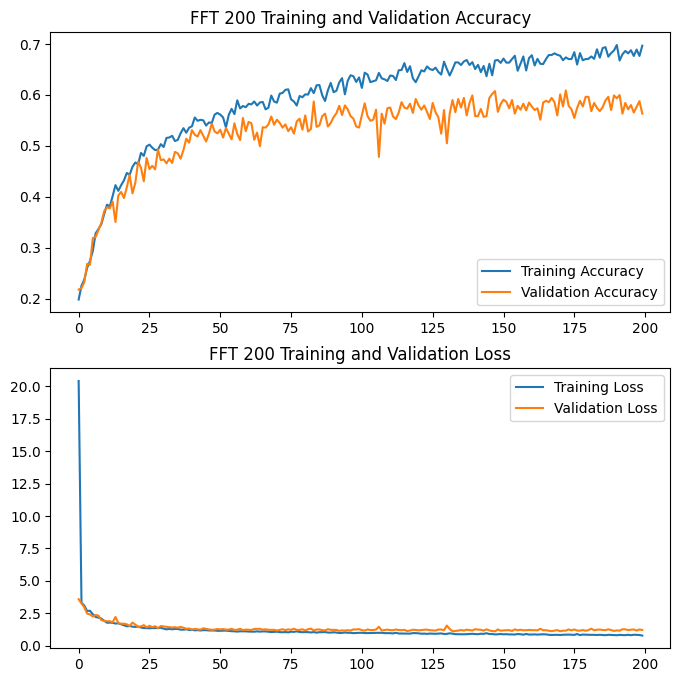

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('FFT 200 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('FFT 200 Training and Validation Loss')
plt.savefig("FFT_Evaluation__epochs")
plt.show()

In [53]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# save to json:  
hist_json_file = 'history_200_FFT.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [66]:
# Evaluation
#model.evaluate(train_dataset, return_dict=True)
#model.evaluate(validation_dataset, return_dict=True)

y_pred = model.predict(train_dataset)
y_pred = tf.argmax(y_pred, axis=1)
print(y_pred)


67/67 [==============================] - 3s 37ms/step
tf.Tensor([2 1 3 ... 2 0 2], shape=(2136,), dtype=int64)


In [62]:
print(np.array(train_dataset))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2023-11-02 11:10:52.293925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2136]
	 [[{{node Placeholder/_0}}]]
2023-11-02 11:10:52.294547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2136]
	 [[{{node Placeholder/_4}}]]


tf.Tensor([5 0 4 ... 5 2 3], shape=(2136,), dtype=int32)
[[65 68 95 53 52 24]
 [60 63 98 60 43 29]
 [72 67 78 66 57 23]
 [88 71 71 50 51 28]
 [83 61 89 58 39 33]
 [61 65 77 62 61 15]]


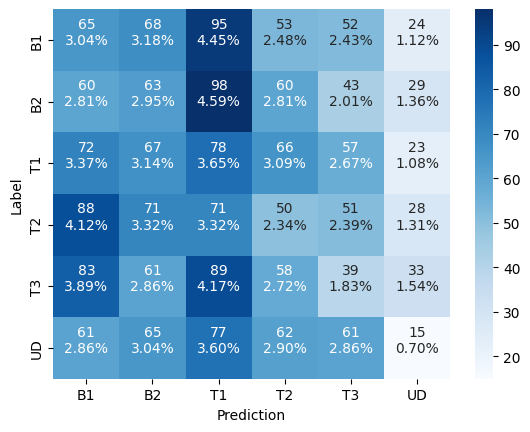

<Figure size 1000x800 with 0 Axes>

In [58]:
# Confusion Matrix

y_true = tf.concat(list(train_dataset.map(lambda s,lab: lab)), axis=0)
print(y_true)

cf_matrix = np.array(tf.math.confusion_matrix(y_true, y_pred))
print(cf_matrix)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix,
                 xticklabels=class_names,
                 yticklabels=class_names,
                 annot=labels, fmt='', cmap='Blues')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.figure(figsize=(10, 8))
plt.savefig("confusion_200_FFT")


In [13]:
from keras.optimizers import Adam
# Fine Tuning

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# keras.utils.plot_model(model, "mk2", show_shapes=True)
model.summary()
print("Learning rate rn :", model.optimizer.learning_rate.numpy())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 160, 160, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 20, 20, 16)        0         
                                                             

In [14]:
# Start fine tuning
fine_tune_epochs = 100
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 120/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


68/68 [==============================] - 9s 125ms/step - loss: 0.7311 - accuracy: 0.7157 - val_loss: 0.9996 - val_accuracy: 0.6272
Epoch 121/200
68/68 [==============================] - 8s 122ms/step - loss: 0.7315 - accuracy: 0.7334 - val_loss: 0.9828 - val_accuracy: 0.6321
Epoch 122/200
68/68 [==============================] - 9s 125ms/step - loss: 0.7130 - accuracy: 0.7301 - val_loss: 0.9734 - val_accuracy: 0.6453
Epoch 123/200
68/68 [==============================] - 9s 125ms/step - loss: 0.7099 - accuracy: 0.7343 - val_loss: 0.9832 - val_accuracy: 0.6369
Epoch 124/200
68/68 [==============================] - 9s 123ms/step - loss: 0.7072 - accuracy: 0.7371 - val_loss: 0.9656 - val_accuracy: 0.6564
Epoch 125/200
68/68 [==============================] - 9s 129ms/step - loss: 0.7007 - accuracy: 0.7413 - val_loss: 0.9548 - val_accuracy: 0.6578
Epoch 126/200
68/68 [==============================] - 9s 128ms/step - loss: 0.7023 - accuracy: 0.7385 - val_loss: 0.9628 - val_accuracy: 0.6481

In [51]:
# Evaluation

model.evaluate(train_dataset, return_dict=True)
model.evaluate(validation_dataset, return_dict=True)

y_pred = model.predict(train_dataset)
y_pred = tf.argmax(y_pred, axis=1)


67/67 [==============================] - 3s 38ms/step


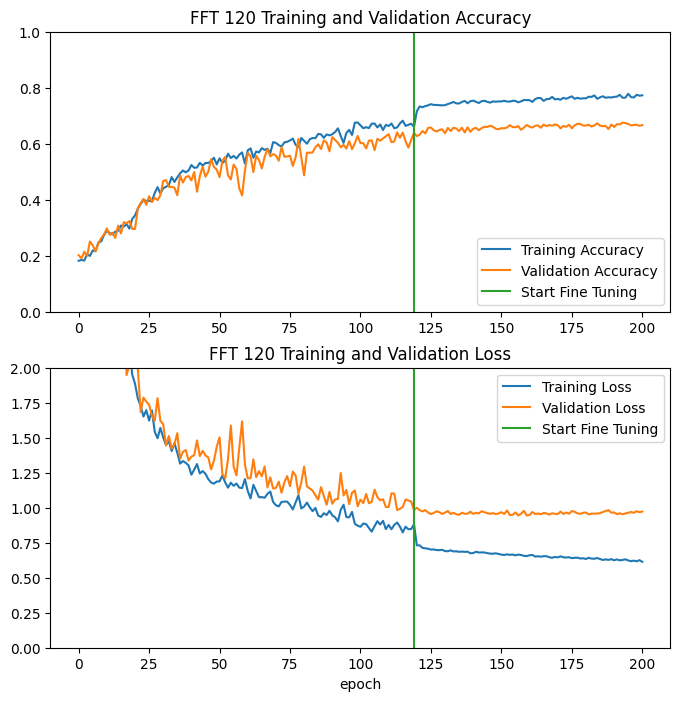

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('FFT 300 Fine Tuned Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([epochs-1, epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('FFT 300 Fine Tuned Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("FFT_Accuracy_300_FT")
plt.show()

2023-10-19 11:48:45.514436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2153]
	 [[{{node Placeholder/_0}}]]
2023-10-19 11:48:45.515064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2153]
	 [[{{node Placeholder/_4}}]]


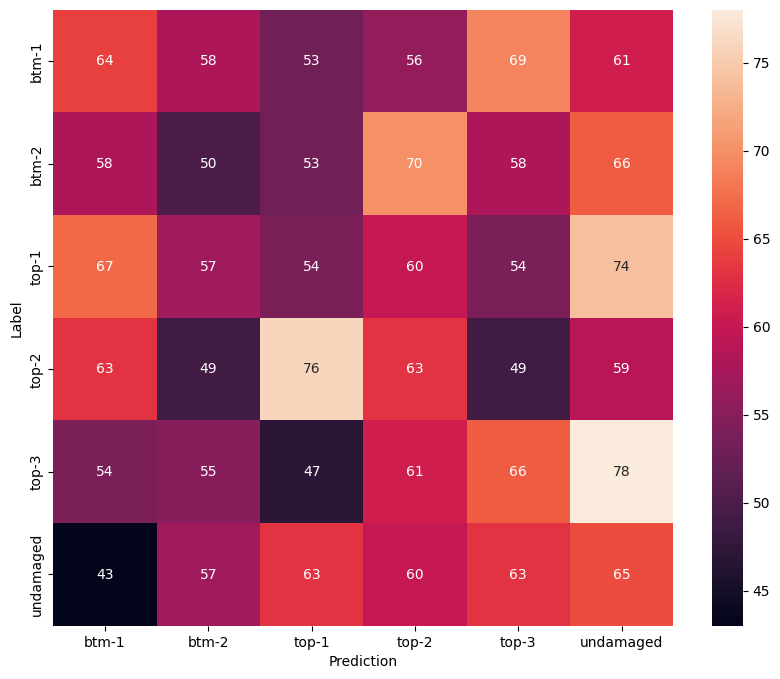

In [17]:
# Confusion Matrix

y_true = tf.concat(list(train_dataset.map(lambda s,lab: lab)), axis=0)

cf_matrix = np.array(tf.math.confusion_matrix(y_true, y_pred))


group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix,
                 xticklabels=class_names,
                 yticklabels=class_names,
                 annot=labels, fmt='', cmap='Blues')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.figure(figsize=(10, 8))
plt.savefig("confusion_200_FFT")
